# Scope Presentation

In [1]:
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from typing import Iterable, Any, List, Dict, TypeVar, cast

from moped import Model

T = TypeVar("T")

print(pkg_resources.get_distribution("moped").version)

1.9.0


## Cofactor effects

In [2]:
def scope_comparison(file):
    m = Model()
    m.read_from_bigg(file)
    m.cofactor_duplication()
    m.reversibility_duplication()
    Scopes = {}
    for i in m.compounds:
        _, cpd = m.scope(["h2o_c", i])
        Scopes[i] = len(cpd)
    Scopes2 = {}
    for i in m.compounds:
        _, cpd = m.scope(["h2o_c", i] + list(m.cofactor_pairs.keys()))
        Scopes2[i] = len(cpd) - len(list(m.cofactor_pairs.keys()))

    Scopes3 = {}
    for i in m.compounds:
        _, cpd = m.scope(["h2o_c", i] + m.get_strong_cofactor_duplications())
        Scopes3[i] = len([i for i in cpd if not cast(str, i).endswith("__cof__")])
    return pd.DataFrame(
        {
            "without cof.": Scopes,
            "actual cof.": Scopes2,
            "cof. duplicates": Scopes3,
        }
    )


def plot_scope(df, ax, name):
    df["without cof."].sort_values().plot(ax=ax, linewidth=3)
    df["actual cof."].sort_values().plot(ax=ax, linewidth=3)
    df["cof. duplicates"].sort_values().plot(ax=ax, linewidth=3)
    ax.set(xticks=[])
    ax.grid()
    ax.set_xlabel("Metabolites")
    ax.set_ylabel("Number of producible Metabolites")
    ax.legend()
    ax.set_title(name, fontsize=15)
    return ax

In [3]:
df1 = scope_comparison("../data/models/iML1515.xml")
df2 = scope_comparison("../data/models/iSynCJ816.xml")
df3 = scope_comparison("../data/models/iYO844.xml")

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


No objective coefficients in model. Unclear what should be optimized


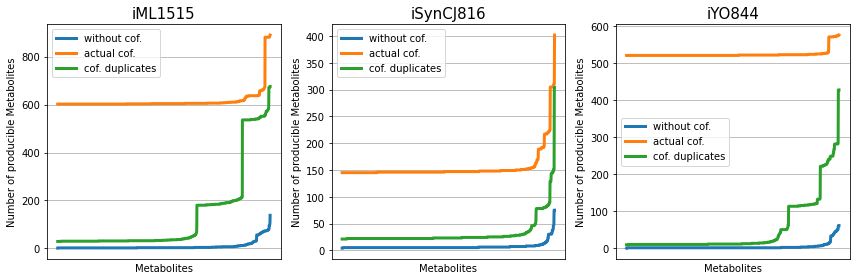

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_scope(df1, ax1, "iML1515")
plot_scope(df2, ax2, "iSynCJ816")
plot_scope(df3, ax3, "iYO844")
plt.tight_layout()
plt.savefig('../figures/scopes_comparison.pdf', bbox_inches="tight")

## Example E.coli core analysis

In [5]:
def snd(x: Any, y: T) -> T:
    return y

def flatten(x: Iterable[Iterable[Any]]) -> List[Any]:
    return [j for i in x for j in i]


def group_mask(groups: Dict[str, List[str]]) -> List[int]:
    return flatten([it.repeat(num, len(group)) for num, group in enumerate(groups.values())])

In [6]:
m = Model()
m.read_from_bigg("../data/models/e_coli_core.xml")

m.cofactor_duplication()
m.reversibility_duplication()

scope_compounds = [i for i in m.compounds if "C" in m.compounds[i].formula and i[-2:] != "_e"]
scopes = {
    i: len(snd(*m.scope([i, "h2o_c"] + m.get_weak_cofactor_duplications())))
    for i in scope_compounds
}

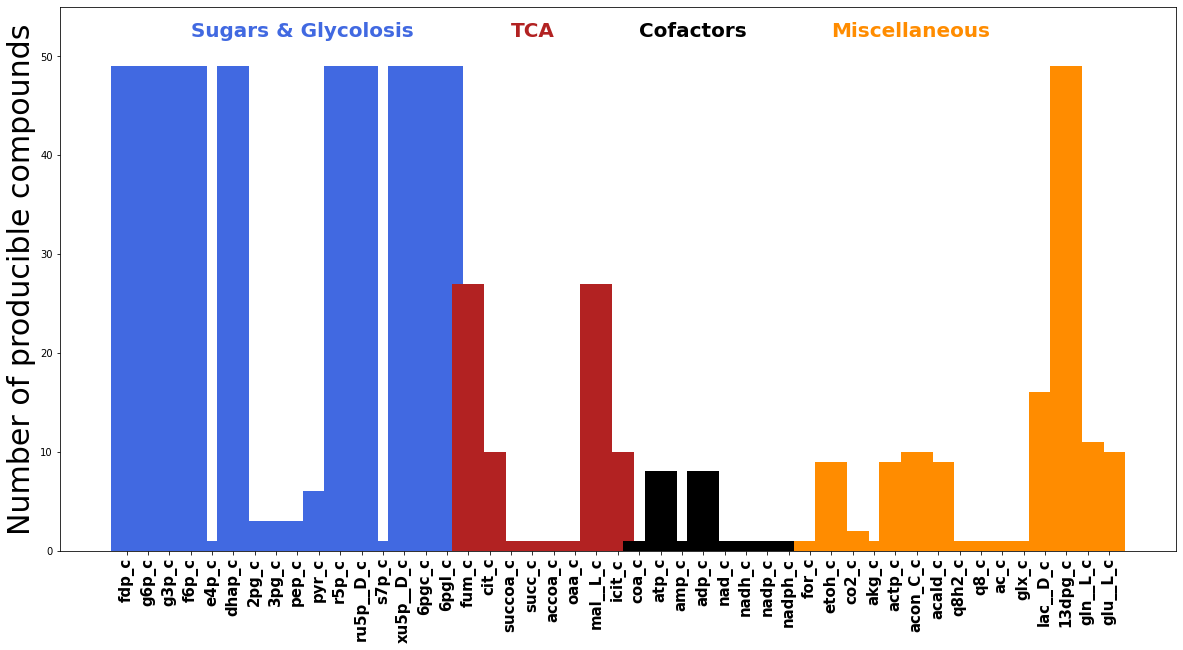

In [7]:
groups = {
    "Glycolosis": [
        "fdp_c",
        "g6p_c",
        "g3p_c",
        "f6p_c",
        "e4p_c",
        "dhap_c",
        "2pg_c",
        "3pg_c",
        "pep_c",
        "pyr_c",
        "r5p_c",
        "ru5p__D_c",
        "s7p_c",
        "xu5p__D_c",
        "6pgc_c",
        "6pgl_c",
    ],
    "TCA": [
        "fum_c",
        "cit_c",
        "succoa_c",
        "succ_c",
        "accoa_c",
        "oaa_c",
        "mal__L_c",
        "icit_c",
    ],
    "Cofactors": [
        "coa_c",
        "atp_c",
        "amp_c",
        "adp_c",
        "nad_c",
        "nadh_c",
        "nadp_c",
        "nadph_c",
    ],
    "Others": [
        "for_c",
        "etoh_c",
        "co2_c",
        "akg_c",
        "actp_c",
        "acon_C_c",
        "acald_c",
        "q8h2_c",
        "q8_c",
        "ac_c",
        "glx_c",
        "lac__D_c",
        "13dpg_c",
        "gln__L_c",
        "glu__L_c",
    ],
}


order = []
for i in list(groups):
    for j in groups[i]:
        order.append(j)

colors = ["royalblue", "firebrick", "black", "darkorange"]
group_colors = [colors[i] for i in group_mask(groups)]


x = flatten(groups.values())
y = [scopes[i] for i in x]


fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y, width=1.5, color=group_colors)
ax.set_ylim(0, 55)
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=90, fontsize=15, fontweight="bold")
ax.text(3, 52, "Sugars & Glycolosis", weight="bold", color="royalblue", fontsize=20)
ax.text(18, 52, "TCA", weight="bold", color="firebrick", fontsize=20)
ax.text(24, 52, "Cofactors", weight="bold", color="black", fontsize=20)
ax.text(33, 52, "Miscellaneous", weight="bold", color="darkorange", fontsize=20)
ax.set_ylabel("Number of producible compounds", fontsize=30)
plt.savefig("../figures/ecoli_core_scope.pdf", bbox_inches="tight")
plt.show()